# PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision 
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import torchmetrics
import torchmetrics

# Import torchinfo
import torchinfo

# Import plotting libraries
import matplotlib.pyplot as plt
import mlxtend

# Other imports
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import random
import zipfile
import os
from PIL import Image
from timeit import default_timer as timer

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Check version
print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)
print(torchinfo.__version__)
print(mlxtend.__version__)
print(device)

2.5.1
0.20.1
1.6.0
1.8.0
0.23.3
mps


## 1. Get data

Our dataset is a subset of the Food101 dataset. Food101 contains 101 different classes of food and 1000 images per class (750 training, 250 testing). Our dataset starts with 3 classes of food and 10% of the data (ca 75 training images, ca 25 testing images).

Why? In ML it is important to try things on a small scale and scale up when necessary, as it helps with faster experimentation.

In [2]:
# Set up path to data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download and extract the data
if image_path.is_dir():
    print(f"{image_path} folder already exists, skipping download.")
else:
    print(f"{image_path} folder does not exist, creating it.")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak and sushi images
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading dataset...")
    f.write(response.content)
    
# Unzip files
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping dataset...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi folder already exists, skipping download.
Unzipping dataset...


## 2. Becoming one with the data aka data preparation and data exploration

In [3]:
def walk_through_dir(dir_path: Path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
# Setup training and test data directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all the image training paths
2. Pick a random image using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with PIL
5. We 'll show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


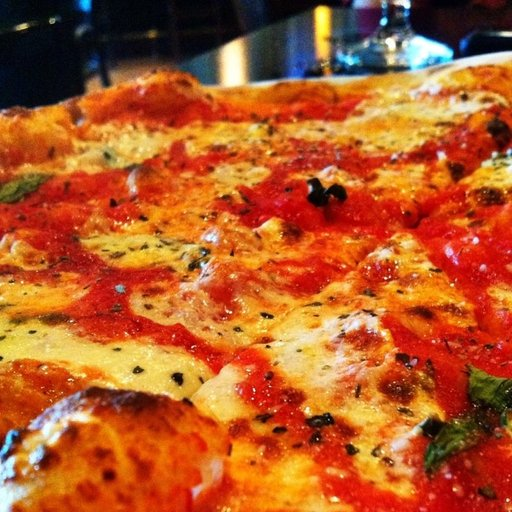

In [6]:
# Set seed
random.seed(42)
#1. Get all the image training paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#2. Pick a random image using `random.choice()`
random_image_path = random.choice(image_path_list)
#3. Get the image class name using `pathlib.Path.parent.stem`
image_class = random_image_path.parent.stem
#4. Since we are working with images, let's open the image with PIL
img = Image.open(random_image_path)
#5. We 'll show the image and print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

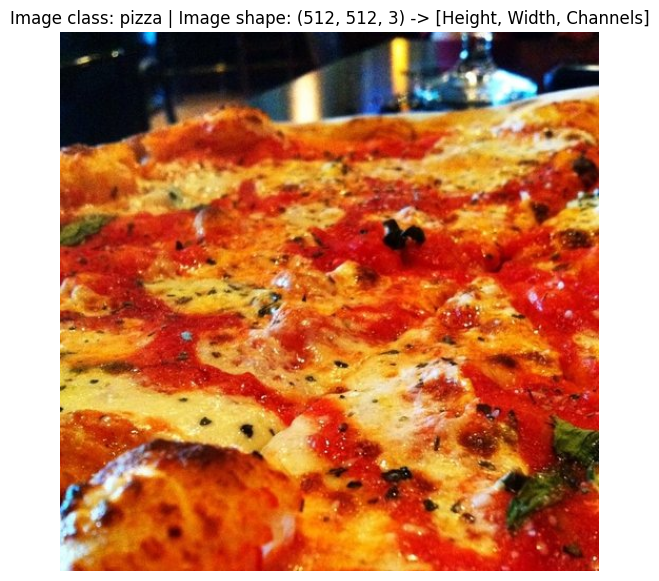

In [7]:
# Turn image into an array
img_array = np.asarray(img)

# Plot image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} -> [Height, Width, Channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with Pytorch: 
1. Turn your target data into tensors
2. Turn it in a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

### 3.1 Transforming data with `torchvision.transforms`

In [8]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the image horizontally (randomly with a 50% chance)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [9]:
data_transform(img)

tensor([[[0.0157, 0.0157, 0.0118,  ..., 0.2314, 0.1922, 0.1020],
         [0.0157, 0.0157, 0.0157,  ..., 0.1137, 0.1059, 0.1216],
         [0.0157, 0.0235, 0.0941,  ..., 0.1098, 0.1255, 0.1569],
         ...,
         [0.8549, 0.8275, 0.8039,  ..., 0.4353, 0.6353, 0.6902],
         [0.8667, 0.8392, 0.7922,  ..., 0.4824, 0.6235, 0.7412],
         [0.8627, 0.7333, 0.7255,  ..., 0.6627, 0.6549, 0.8000]],

        [[0.0588, 0.0510, 0.0392,  ..., 0.0510, 0.0471, 0.0392],
         [0.0549, 0.0471, 0.0431,  ..., 0.0431, 0.0431, 0.0549],
         [0.0667, 0.0706, 0.1176,  ..., 0.0510, 0.0471, 0.0510],
         ...,
         [0.9529, 0.8824, 0.8118,  ..., 0.1098, 0.0627, 0.0627],
         [0.9804, 0.8510, 0.6353,  ..., 0.0667, 0.0824, 0.2353],
         [0.9412, 0.5451, 0.3176,  ..., 0.0745, 0.0980, 0.3098]],

        [[0.1176, 0.0745, 0.0667,  ..., 0.0588, 0.0510, 0.0392],
         [0.1137, 0.0863, 0.0784,  ..., 0.0431, 0.0392, 0.0510],
         [0.0941, 0.0941, 0.1216,  ..., 0.0588, 0.0510, 0.

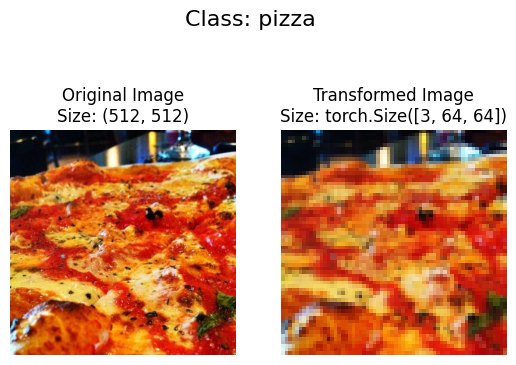

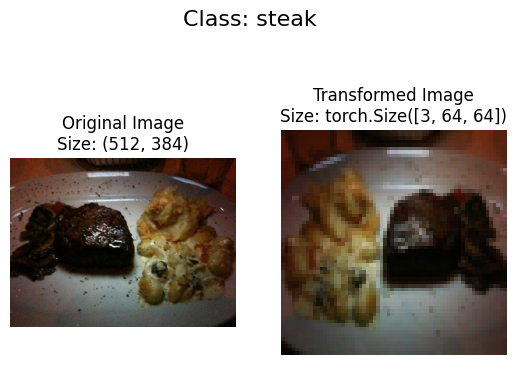

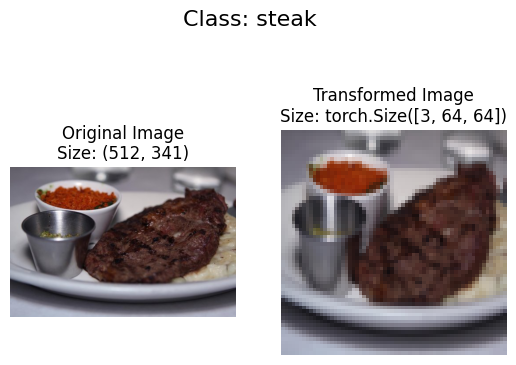

In [10]:
# Write function to plot original and transformed image
def plot_transformed_image(image_paths:list, transform, n=3, seed=None):
    """Selects image from image_paths and plots original and transformed image."""
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Image\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0)) # Change tensor shape from (H, W, C) to (C, H, W)
            ax[1].set_title(f"Transformed Image\nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_image(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## 4 Option 1: Loading image data using `torchvision.datasets.ImageFolder`

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [11]:
# Use ImageFolder to load the data
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dictionary
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, channels]


Text(0.5, 1.0, 'pizza')

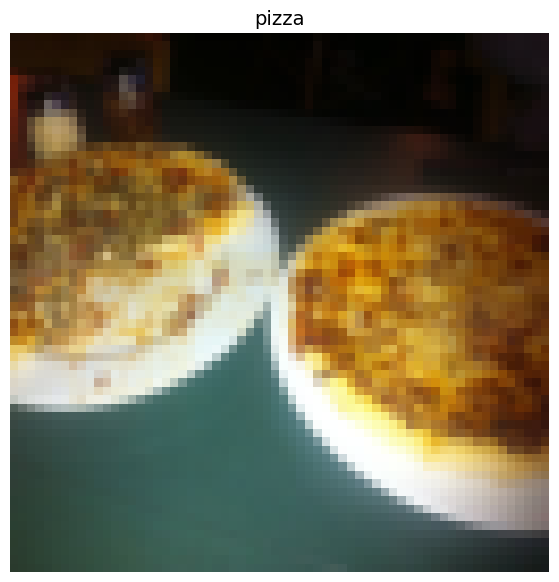

In [15]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out the different shapes
print(f"Original shape: {img.shape} -> [channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

In [16]:
# Turn train and test datasets into DataLoaders
BATCH_SIZE = 1
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               num_workers=1,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=BATCH_SIZE,
                                              num_workers=1,
                                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [17]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with custom dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to classes as dictionary from the dataset

Pros:
* Can create dataset out of almost any data
* Not limited to PyTorch pre-built dataset function

Cons: 
* You can create `Dataset` out of anything, but it might not work
* More code to write, which could lead to more error and performance issues

### 5.1 Creating a helper function to get class names

We want a function to: 
1. Get the class names using `os.scandir()` to traverse a target directory, which is ideally in standard image classification format (i.e. `train` and `test` directories.)
2. Raise an error if the class names are not found (e.g. wrong directory structure).
3. Turn the class names into a dictionary and list and return them.

In [18]:
# Setup path for target directory
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [19]:
def find_classes(directory: Path) -> tuple[list[str], dict[str, int]]:
    """
    Returns the class names and class indices in a given directory.
    """
    # 1. Get the class names by scanning the directory
    classes = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])
    
    # 2. Raise an error if no class is found
    if not classes:
        raise FileNotFoundError(f"No class directories in {directory}. Please check file structure.")
    
    # 3. Create a dictionary of class names and their indices
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [20]:
class_names, class_to_idx = find_classes(target_dir)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we need to: 
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a target directory and a transform we want to apply.
3. Create several attributes:
* paths - paths to our images
* transform - the transform we want to apply
* classes - a list of the target classes
* class_to_idx - a dictionary mapping classes to indices
4. Create a function to `load_images()` which opens an image.
5. Overwrite the `__len__` method to return the length of the dataset.
6. Overwrite the `__getitem__` method to return a given sample when given its index.

In [21]:
# 1. Subclass `torch.utils.data.Dataset`.
class ImageFolderCustom(torch.utils.data.Dataset):
    # 2. Initialize our subclass with a target directory and a transform we want to apply.
    def __init__(self, target_dir: Path, transform=None):
        # 3. Create class attributes
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Get class names and class indices
        self.classes, self.class_to_idx = find_classes(target_dir)
        
    # 4. Create a function to `load_images()` which opens an image.
    def load_image(self, index: int):
        """Opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite the `__len__` method to return the length of the dataset.
    def __len__(self):
        """Returns the length of the dataset"""
        return len(self.paths)
    
    # 6. Overwrite the `__getitem__` method to return a given sample when given its index.
    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        """Returns the sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx  

In [22]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [23]:
# Test out the ImageFolderCustom class
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                    transform=train_transforms)

test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                    transform=test_transforms)

In [24]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x146779ca0>,
 <__main__.ImageFolderCustom at 0x145d645c0>)

In [25]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [26]:
# Check for equality between ImageFolder and ImageFolderCustom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [27]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n it too high
    if n > 10:
        print("Number of images to display is too high, displaying first 10 images.")
        display_shape = False
        n = 10
        
    # 3. Set the random seed for reproducibility
    if seed:
        random.seed(seed)
        
    # 4. Get a list of random sample indexes from the target dataset.
    random_sample_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup a matplotlib plot.
    plt.figure(figsize=(16, 8))
    
    # 6. Loop through the random sample indexes and plot them with matploltib.
    for i, target_sample in enumerate(random_sample_idx):
        target_img, target_label = dataset[target_sample][0], dataset[target_sample][1]
        
        # 7. Make sure the dimensions of our images line up with matplotlib (HWC)
        target_img_permute = target_img.permute(1, 2, 0)
        
        # Plot adjusted images
        plt.subplot(1, n, i + 1)
        plt.imshow(target_img_permute)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title += f"\nShape: {target_img_permute.shape}"
        plt.title(title)

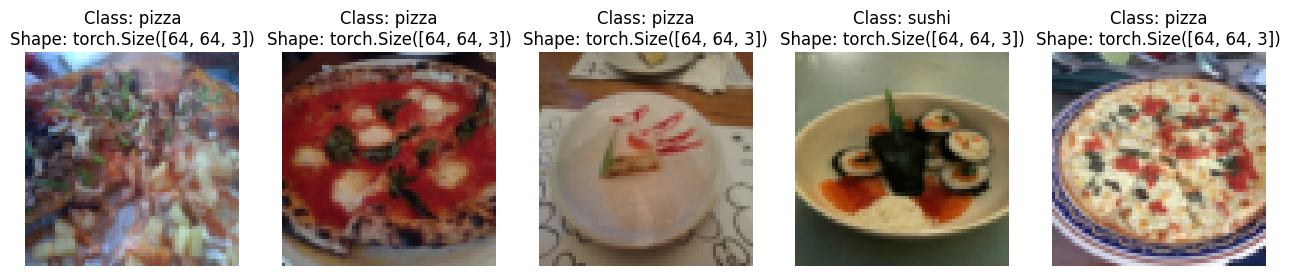

In [28]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

Number of images to display is too high, displaying first 10 images.


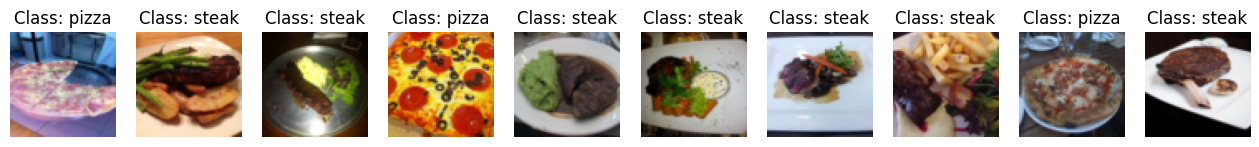

In [29]:
# Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom, n=20, classes=class_names, seed=42)

### 5.4 Turn custom loaded images into DataLoaders

In [30]:
BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoaders
train_dataloader_custom = torch.utils.data.DataLoader(dataset=train_data_custom,
                                                      batch_size=BATCH_SIZE,
                                                      num_workers=NUM_WORKERS,
                                                      shuffle=True)

test_dataloader_custom = torch.utils.data.DataLoader(dataset=test_data_custom,
                                                    batch_size=BATCH_SIZE,
                                                    num_workers=NUM_WORKERS,
                                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x146a4b980>,
 <torch.utils.data.dataloader.DataLoader at 0x146a20110>)

In [31]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [32]:
# Let's look at `trivialaugment` - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide 

train_tranform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_tranform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [33]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

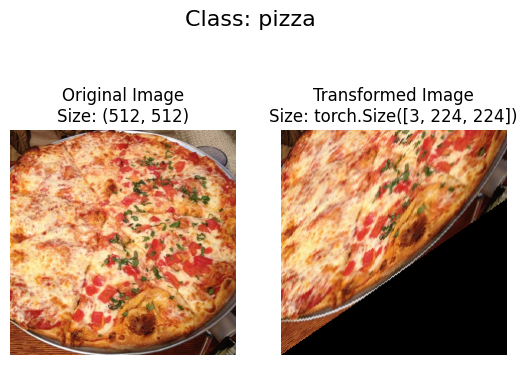

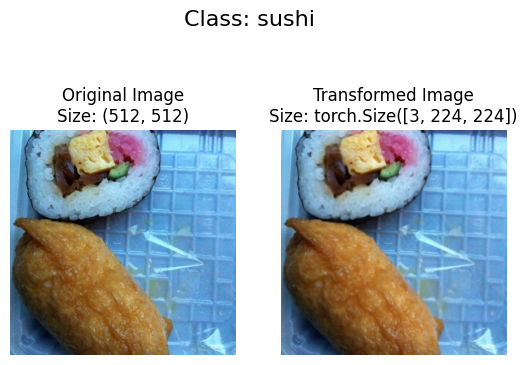

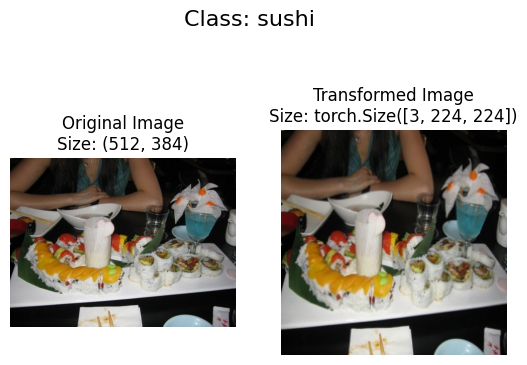

In [34]:
# Plot random transformed images
plot_transformed_image(image_paths=image_path_list,
                       transform=train_tranform,
                       n=3,
                       seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [35]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [36]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn data into dataloaders
# Setup up batch size and number of workers
BATCH_SIZE=32
NUM_WORKERS=0

# Create dataloaders
train_dataloader_simple = torch.utils.data.DataLoader(dataset=train_data_simple,
                                                      batch_size=BATCH_SIZE,
                                                      num_workers=NUM_WORKERS,
                                                      shuffle=True)

test_dataloader_simple = torch.utils.data.DataLoader(dataset=test_data_simple,
                                                      batch_size=BATCH_SIZE,
                                                      num_workers=NUM_WORKERS,
                                                      shuffle=False)

### 7.2 Create TinyVGG model class

In [37]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13, # 13 * 13 is the output shape of the second conv block
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x 

In [38]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [39]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape
     

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [40]:
# Try a forward pass
model_0(image_batch.to(device))     

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2131e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get an idea of the shapes going through our model

In [41]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [42]:
# Create train step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()
    
    #Setup train loss and accuracy metrics
    train_loss, train_acc = 0, 0
    
    #Loop through data batches in dataloader
    for batch, (X, y) in enumerate(dataloader):
        #Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X) # outputs logits
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Backpropagation
        loss.backward()
        # 5. Optimizer step
        optimizer.step() 
    
        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    # Adjust metrics to get average loss and accuracy pre batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [43]:
# Create test step function
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
    # Put the model in eval mode
    model.eval;()
    
    #Setup test loss and accuracy metrics
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        #Loop through data batches in dataloader    
        for batch, (X, y) in enumerate(dataloader):
            #Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X) # outputs logits
            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item() 
        
            # Calculate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_logits)
        
        # Adjust metrics to get average loss and accuracy pre batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        
    return test_loss, test_acc

### 7.6 Creating a train() function to combine train_step() and test_step()

In [44]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model_0

In [91]:
# Set random seeds
torch.manual_seed(42) 

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer() 

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0844 | Train acc: 0.4023 | Test loss: 1.0607 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0663 | Train acc: 0.4180 | Test loss: 1.0658 | Test acc: 0.5644
Total training time: 1.799 seconds


### 7.8 Plot the loss curves of Model 0

A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [46]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary"""
    # Get the loss values of the results dictionary (training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get the accuracy values of the results dictionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    # Get epoch number
    epochs = range(len(results["train_loss"]))
    
    # Setup the graph
    plt.figure(figsize=(15,7))
    
    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
     # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

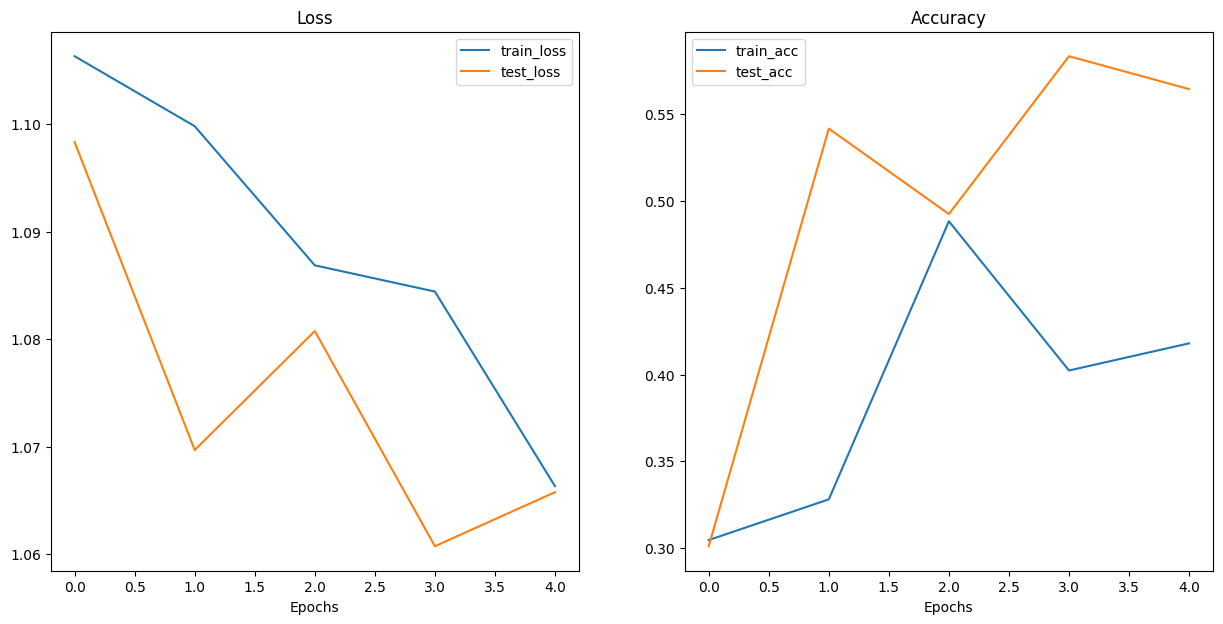

In [92]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [56]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [67]:
# Turn image folders in datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [74]:
# Turn datasets into dataloaders
BATCH_SIZE=32
NUM_WORKERS=0

torch.manual_seed(42)
train_dataloader_augmented = torch.utils.data.DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = torch.utils.data.DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### 9.3 Train and evaluate model_1

In [81]:
# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [87]:
# Set random seeds
torch.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 1.0658 | Train acc: 0.4844 | Test loss: 1.0504 | Test acc: 0.2812
Epoch: 1 | Train loss: 1.0311 | Train acc: 0.4453 | Test loss: 1.0866 | Test acc: 0.3021
Epoch: 2 | Train loss: 1.0883 | Train acc: 0.3828 | Test loss: 1.1208 | Test acc: 0.2917
Epoch: 3 | Train loss: 1.0266 | Train acc: 0.4336 | Test loss: 1.0685 | Test acc: 0.3636
Epoch: 4 | Train loss: 1.0356 | Train acc: 0.4062 | Test loss: 1.0394 | Test acc: 0.3845
Total training time for model_1: 1.795 seconds


### 9.4 Plot the loss curves of model 1

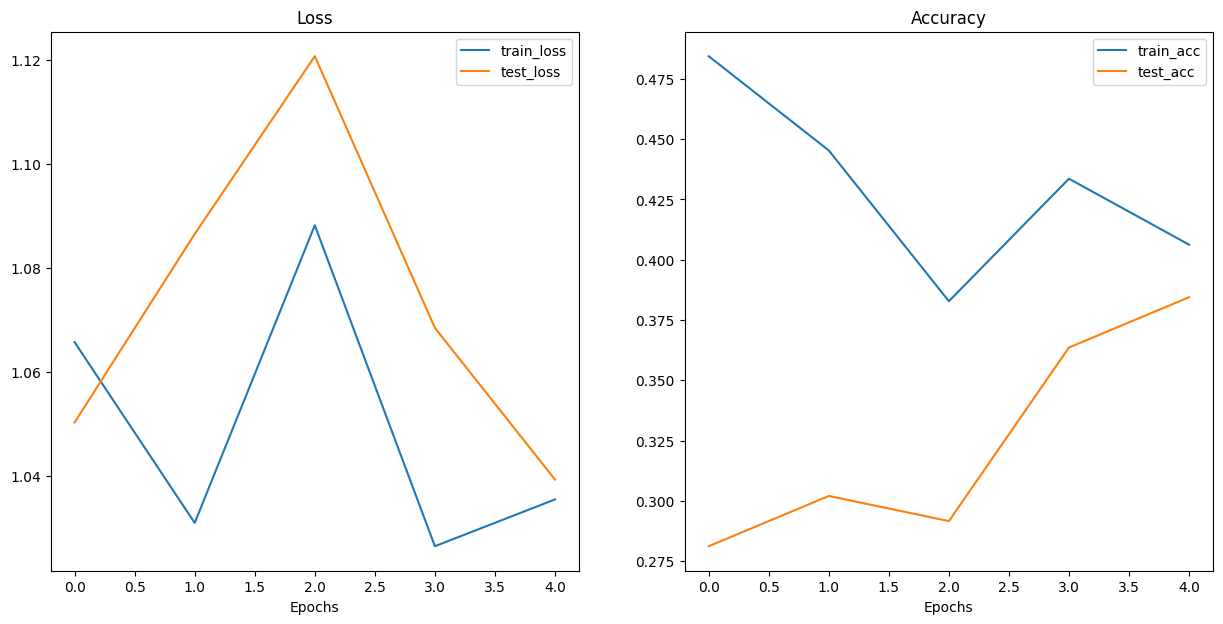

In [88]:
plot_loss_curves(model_1_results) 

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [93]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098322,0.301136
1,1.099807,0.328125,1.069683,0.541667
2,1.086866,0.488281,1.080751,0.492424
3,1.084425,0.402344,1.060733,0.583333
4,1.066320,0.417969,1.065759,0.564394


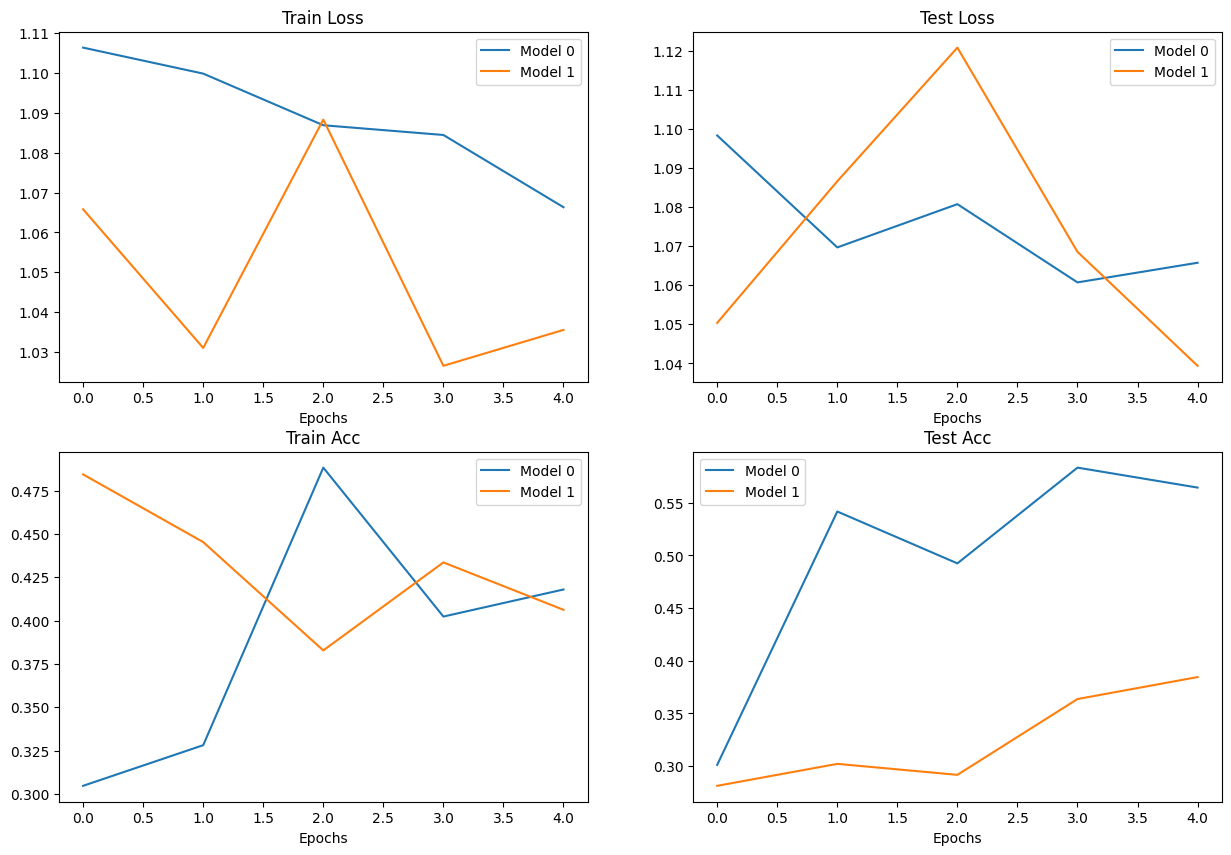

In [94]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [95]:
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")


### 11.1 Loading in a custom image with PyTorch
We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [96]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [97]:
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

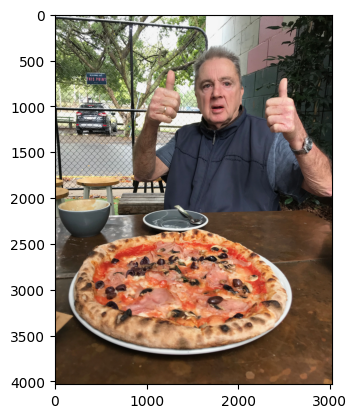

In [98]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [99]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [100]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [101]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (10x756765 and 1690x3)

In [102]:
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


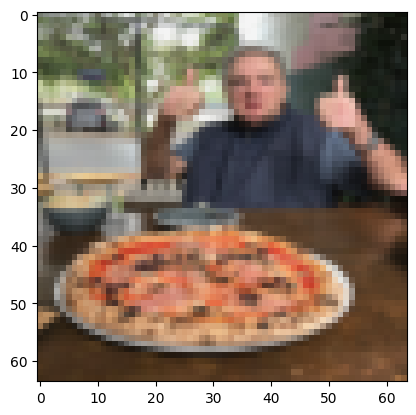

In [103]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [104]:
# This will error: image not on right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [105]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))    

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (10x169 and 1690x3)

In [106]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [107]:
# This should this work? (added a batch size...)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1017, -0.4618, -0.2607]], device='mps:0')

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [108]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4415, 0.2513, 0.3073]], device='mps:0')

In [109]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [110]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [112]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

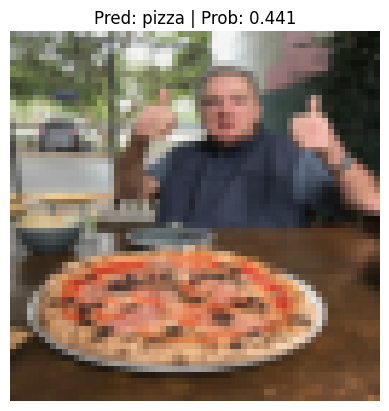

In [113]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)